#  IEEE-CIS Fraud Detection - Решение без использования LightAutoML.

Цель: превзойти результаты LAMA baseline.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
import sys
import warnings
import gc
import time
import logging
from pathlib import Path
from datetime import datetime
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [4]:
from feature_transformers import (
    TimeFeatureTransformer,
    UIDFeatureTransformer,     
    DNormalizationTransformer,  
    FrequencyEncoder,
    AggregationTransformer,
    MissingIndicatorTransformer,
    FeatureSelector
)

In [5]:
from utils import (
    load_data, 
    create_time_features,
    create_uid_features,
    normalize_d_features,
    create_frequency_features,
    create_aggregation_features,
    get_feature_types
)

In [6]:
from pathlib import Path
from dataclasses import dataclass
from typing import List
from utils import load_data

DATA_DIR = Path("data")
SUBMISSIONS_DIR = Path("submissions")

In [7]:
@dataclass
class FeatureConfig:
    """Конфигурация признаков датасета"""
    cat_transaction = None
    cat_identity = None
    target = "isFraud"
    id_col = "TransactionID"
    time_col = "TransactionDT"

FEATURE_CONFIG = FeatureConfig()

train, test, sample_sub = load_data(DATA_DIR)

Train shape: (590540, 434), Test shape: (506691, 433)


In [8]:
target = FEATURE_CONFIG.target
id_col = FEATURE_CONFIG.id_col

In [9]:
train_sorted = train.sort_values('TransactionDT').reset_index(drop=True)
split_idx = int(len(train_sorted) * 0.8)

train_data = train_sorted.iloc[:split_idx].copy()
val_data = train_sorted.iloc[split_idx:].copy()

X_train = train_data.drop(columns=[target, id_col])
y_train = train_data[target]
X_val = val_data.drop(columns=[target, id_col])
y_val = val_data[target]

In [10]:
# Типизация признаков с использованием функции, автоматически определяющей тип данных
feature_types = get_feature_types(train, target)

Numeric: 394, Categorical: 31, Binary: 7


In [11]:
cat_cols = feature_types['categorical'] + feature_types['binary']

In [12]:
# Группы колонок для агрегаций
group_cols = ['card1', 'card2', 'addr1', 'P_emaildomain']
agg_cols = ['TransactionAmt', 'D1', 'D2']

In [13]:
preprocessing_pipeline = Pipeline([
    ('time_features', TimeFeatureTransformer()),
    ('uid_features', UIDFeatureTransformer()),
    ('d_normalization', DNormalizationTransformer()),
    ('frequency_encoding', FrequencyEncoder(cols=cat_cols[:10])),
    ('aggregations', AggregationTransformer(
        group_cols=group_cols,
        agg_cols=agg_cols,
        agg_funcs=['sum', 'mean', 'std']
    )),
    ('missing_indicator', MissingIndicatorTransformer()),
    ('feature_selector', FeatureSelector(
        exclude_cols=[id_col] + cat_cols
    ))
])

In [14]:
X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_val_processed = preprocessing_pipeline.transform(X_val)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_val_processed shape: {X_val_processed.shape}")

X_train_processed shape: (472432, 484)
X_val_processed shape: (118108, 484)


In [15]:
train_pool = Pool(X_train_processed, label=y_train)
val_pool = Pool(X_val_processed, label=y_val)

## Попытка 1: CatBoost (Базовые параметры)

In [16]:
start_time = time.time()

catboost_config1 = CatBoostClassifier(
    iterations=10_000,
    learning_rate=0.02,
    depth=4,
    random_seed=42,
    task_type='GPU',
    devices='0',
    eval_metric='AUC',
    early_stopping_rounds=100,
    verbose=100
)

catboost_config1.fit(train_pool, eval_set=val_pool)

train_time_config1 = time.time() - start_time

val_pred_config1 = catboost_config1.predict_proba(X_val_processed)[:, 1]
val_auc_config1 = roc_auc_score(y_val, val_pred_config1)

print(f"Время обучения: {train_time_config1 / 60:.1f} минут")
print(f"Validation ROC-AUC (config 1): {val_auc_config1:.5f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6552547	best: 0.6552547 (0)	total: 51.9ms	remaining: 8m 39s
100:	test: 0.8356723	best: 0.8356723 (100)	total: 620ms	remaining: 1m
200:	test: 0.8458920	best: 0.8459037 (197)	total: 1.16s	remaining: 56.4s
300:	test: 0.8514184	best: 0.8514184 (300)	total: 1.76s	remaining: 56.7s
400:	test: 0.8554887	best: 0.8554887 (400)	total: 2.32s	remaining: 55.6s
500:	test: 0.8590956	best: 0.8590956 (500)	total: 2.87s	remaining: 54.4s
600:	test: 0.8624168	best: 0.8624168 (600)	total: 3.48s	remaining: 54.4s
700:	test: 0.8646622	best: 0.8646877 (698)	total: 4.06s	remaining: 53.8s
800:	test: 0.8662141	best: 0.8662430 (799)	total: 4.68s	remaining: 53.7s
900:	test: 0.8672282	best: 0.8672282 (900)	total: 5.31s	remaining: 53.6s
1000:	test: 0.8685184	best: 0.8685374 (998)	total: 5.93s	remaining: 53.3s
1100:	test: 0.8696802	best: 0.8696802 (1100)	total: 6.58s	remaining: 53.2s
1200:	test: 0.8707344	best: 0.8707344 (1200)	total: 7.23s	remaining: 53s
1300:	test: 0.8711323	best: 0.8711793 (1284)	total: 7

## Попытка 2: CatBoost (Optuna)

In [18]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    """Objective function для оптуны"""
    
    params = {
        'iterations': 5_000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 6, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'bootstrap_type': 'Bernoulli',
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_seed': 42,
        'task_type': 'GPU',
        'devices': '0',
        'eval_metric': 'AUC',
        'early_stopping_rounds': 100,
        'verbose': 500
    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=val_pool)
    
    val_pred = model.predict_proba(X_val_processed)[:, 1]
    auc = roc_auc_score(y_val, val_pred)
    
    return auc

start_time = time.time()

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

study.optimize(
    objective, 
    n_trials=50,
    show_progress_bar=True
)

optuna_time = time.time() - start_time
print(f"Время оптимизации: {optuna_time/60:.1f} минут")

  0%|          | 0/50 [00:00<?, ?it/s]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6913369	best: 0.6913369 (0)	total: 8.81ms	remaining: 44s
500:	test: 0.9133353	best: 0.9133817 (499)	total: 39.9s	remaining: 5m 58s
1000:	test: 0.9227067	best: 0.9227217 (999)	total: 1m 19s	remaining: 5m 17s
bestTest = 0.9248523712
bestIteration = 1286
Shrink model to first 1287 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7613806	best: 0.7613806 (0)	total: 7.88ms	remaining: 39.4s
500:	test: 0.8671538	best: 0.8671538 (500)	total: 3.68s	remaining: 33.1s
1000:	test: 0.8784672	best: 0.8784672 (1000)	total: 7.3s	remaining: 29.2s
1500:	test: 0.8841289	best: 0.8841303 (1498)	total: 10.9s	remaining: 25.5s
2000:	test: 0.8876891	best: 0.8876891 (2000)	total: 14.5s	remaining: 21.8s
2500:	test: 0.8905410	best: 0.8905410 (2500)	total: 18.2s	remaining: 18.1s
3000:	test: 0.8931040	best: 0.8931040 (3000)	total: 21.8s	remaining: 14.5s
3500:	test: 0.8956242	best: 0.8956242 (3500)	total: 25.5s	remaining: 10.9s
4000:	test: 0.8976337	best: 0.8976510 (3991)	total: 29.2s	remaining: 7.28s
4500:	test: 0.9001526	best: 0.9001668 (4498)	total: 32.8s	remaining: 3.63s
4999:	test: 0.9019338	best: 0.9019845 (4990)	total: 36.4s	remaining: 0us
bestTest = 0.9019845426
bestIteration = 4990
Shrink model to first 4991 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6913369	best: 0.6913369 (0)	total: 9.01ms	remaining: 45s
500:	test: 0.8941569	best: 0.8941569 (500)	total: 39.6s	remaining: 5m 55s
1000:	test: 0.9095612	best: 0.9095612 (1000)	total: 1m 18s	remaining: 5m 15s
1500:	test: 0.9175665	best: 0.9175665 (1500)	total: 1m 58s	remaining: 4m 35s
2000:	test: 0.9229387	best: 0.9229432 (1993)	total: 2m 37s	remaining: 3m 56s
2500:	test: 0.9255088	best: 0.9255088 (2500)	total: 3m 16s	remaining: 3m 16s
3000:	test: 0.9273629	best: 0.9273689 (2999)	total: 3m 56s	remaining: 2m 37s
bestTest = 0.9276423454
bestIteration = 3107
Shrink model to first 3108 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6913369	best: 0.6913369 (0)	total: 6.23ms	remaining: 31.2s
500:	test: 0.8835522	best: 0.8835522 (500)	total: 5.73s	remaining: 51.5s
1000:	test: 0.8966497	best: 0.8966497 (1000)	total: 11.3s	remaining: 45.3s
1500:	test: 0.9042137	best: 0.9043490 (1495)	total: 17s	remaining: 39.5s
2000:	test: 0.9070845	best: 0.9077389 (1964)	total: 22.7s	remaining: 34.1s
bestTest = 0.9077388644
bestIteration = 1964
Shrink model to first 1965 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7613806	best: 0.7613806 (0)	total: 9.29ms	remaining: 46.5s
500:	test: 0.8842629	best: 0.8843538 (453)	total: 4.03s	remaining: 36.2s
1000:	test: 0.8956383	best: 0.8956383 (1000)	total: 8.34s	remaining: 33.3s
1500:	test: 0.9018303	best: 0.9019068 (1493)	total: 12s	remaining: 28.1s
bestTest = 0.9031027853
bestIteration = 1598
Shrink model to first 1599 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7788626	best: 0.7788626 (0)	total: 10.3ms	remaining: 51.4s
500:	test: 0.8924679	best: 0.8927618 (483)	total: 4.22s	remaining: 37.9s
bestTest = 0.9001441598
bestIteration = 818
Shrink model to first 819 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7788299	best: 0.7788299 (0)	total: 11.5ms	remaining: 57.6s
500:	test: 0.8943115	best: 0.8943807 (472)	total: 5.17s	remaining: 46.4s
1000:	test: 0.8998795	best: 0.8999084 (997)	total: 9.73s	remaining: 38.9s
bestTest = 0.8999084234
bestIteration = 997
Shrink model to first 998 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7824336	best: 0.7824336 (0)	total: 12.9ms	remaining: 1m 4s
500:	test: 0.8954203	best: 0.8969512 (491)	total: 6.39s	remaining: 57.4s
bestTest = 0.8969511688
bestIteration = 491
Shrink model to first 492 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6913369	best: 0.6913369 (0)	total: 7.36ms	remaining: 36.8s
500:	test: 0.8842776	best: 0.8842776 (500)	total: 8.75s	remaining: 1m 18s
1000:	test: 0.8996195	best: 0.8996195 (1000)	total: 17.1s	remaining: 1m 8s
1500:	test: 0.9060919	best: 0.9061314 (1497)	total: 25.7s	remaining: 59.8s
2000:	test: 0.9080234	best: 0.9080234 (2000)	total: 34.3s	remaining: 51.5s
bestTest = 0.90979743
bestIteration = 2256
Shrink model to first 2257 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6913369	best: 0.6913369 (0)	total: 7.49ms	remaining: 37.4s
500:	test: 0.8963037	best: 0.8973575 (455)	total: 6.09s	remaining: 54.7s
1000:	test: 0.9040020	best: 0.9042669 (982)	total: 11.6s	remaining: 46.4s
bestTest = 0.9047659039
bestIteration = 1054
Shrink model to first 1055 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8168373	best: 0.8168373 (0)	total: 79.7ms	remaining: 6m 38s
500:	test: 0.9078336	best: 0.9078336 (500)	total: 39.8s	remaining: 5m 57s
1000:	test: 0.9214233	best: 0.9214385 (999)	total: 1m 19s	remaining: 5m 16s
1500:	test: 0.9266108	best: 0.9266108 (1500)	total: 1m 59s	remaining: 4m 38s
2000:	test: 0.9288256	best: 0.9288723 (1997)	total: 2m 39s	remaining: 3m 59s
bestTest = 0.9290229678
bestIteration = 2054
Shrink model to first 2055 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8163998	best: 0.8163998 (0)	total: 95.8ms	remaining: 7m 58s
500:	test: 0.9091024	best: 0.9091173 (498)	total: 39.9s	remaining: 5m 58s
1000:	test: 0.9216629	best: 0.9216629 (1000)	total: 1m 19s	remaining: 5m 18s
1500:	test: 0.9276426	best: 0.9276570 (1488)	total: 1m 59s	remaining: 4m 38s
2000:	test: 0.9299050	best: 0.9299074 (1942)	total: 2m 38s	remaining: 3m 58s
bestTest = 0.9305749238
bestIteration = 2286
Shrink model to first 2287 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8163925	best: 0.8163925 (0)	total: 54ms	remaining: 4m 30s
500:	test: 0.9039468	best: 0.9039468 (500)	total: 22.2s	remaining: 3m 19s
1000:	test: 0.9168949	best: 0.9168949 (1000)	total: 44.1s	remaining: 2m 56s
1500:	test: 0.9237561	best: 0.9237726 (1493)	total: 1m 6s	remaining: 2m 34s
2000:	test: 0.9267263	best: 0.9267789 (1994)	total: 1m 28s	remaining: 2m 12s
2500:	test: 0.9283276	best: 0.9283276 (2500)	total: 1m 50s	remaining: 1m 50s
bestTest = 0.9290158153
bestIteration = 2770
Shrink model to first 2771 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8163145	best: 0.8163145 (0)	total: 57.4ms	remaining: 4m 46s
500:	test: 0.9058107	best: 0.9058107 (500)	total: 22.4s	remaining: 3m 21s
1000:	test: 0.9183428	best: 0.9183428 (1000)	total: 44.4s	remaining: 2m 57s
1500:	test: 0.9237548	best: 0.9237548 (1500)	total: 1m 6s	remaining: 2m 34s
2000:	test: 0.9265341	best: 0.9265353 (1999)	total: 1m 28s	remaining: 2m 12s
2500:	test: 0.9281851	best: 0.9282948 (2456)	total: 1m 50s	remaining: 1m 50s
bestTest = 0.9283283949
bestIteration = 2522
Shrink model to first 2523 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7938623	best: 0.7938623 (0)	total: 36.3ms	remaining: 3m 1s
500:	test: 0.8976840	best: 0.8976856 (498)	total: 13.5s	remaining: 2m 1s
1000:	test: 0.9117622	best: 0.9117622 (1000)	total: 26.7s	remaining: 1m 46s
1500:	test: 0.9178844	best: 0.9178844 (1500)	total: 39.9s	remaining: 1m 33s
bestTest = 0.9187696874
bestIteration = 1689
Shrink model to first 1690 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7928493	best: 0.7928493 (0)	total: 54.7ms	remaining: 4m 33s
bestTest = 0.9101852775
bestIteration = 280
Shrink model to first 281 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8225976	best: 0.8225976 (0)	total: 98.9ms	remaining: 8m 14s
500:	test: 0.9185932	best: 0.9185932 (500)	total: 40.2s	remaining: 6m
1000:	test: 0.9255268	best: 0.9255707 (972)	total: 1m 20s	remaining: 5m 19s
bestTest = 0.9263338149
bestIteration = 1372
Shrink model to first 1373 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7928143	best: 0.7928143 (0)	total: 32.1ms	remaining: 2m 40s
500:	test: 0.8996663	best: 0.8996663 (500)	total: 13.1s	remaining: 1m 57s
1000:	test: 0.9123244	best: 0.9125618 (980)	total: 26.1s	remaining: 1m 44s
bestTest = 0.9129609168
bestIteration = 1100
Shrink model to first 1101 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7940076	best: 0.7940076 (0)	total: 32.4ms	remaining: 2m 42s
500:	test: 0.9063479	best: 0.9063479 (500)	total: 13.2s	remaining: 1m 58s
1000:	test: 0.9181140	best: 0.9181140 (1000)	total: 26.3s	remaining: 1m 45s
1500:	test: 0.9212935	best: 0.9216370 (1432)	total: 39.4s	remaining: 1m 31s
bestTest = 0.9216369689
bestIteration = 1432
Shrink model to first 1433 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8164342	best: 0.8164342 (0)	total: 96.8ms	remaining: 8m 3s
500:	test: 0.9034037	best: 0.9034037 (500)	total: 40s	remaining: 5m 59s
1000:	test: 0.9170137	best: 0.9170250 (998)	total: 1m 19s	remaining: 5m 17s
1500:	test: 0.9237190	best: 0.9237461 (1497)	total: 1m 59s	remaining: 4m 37s
2000:	test: 0.9274848	best: 0.9274999 (1989)	total: 2m 38s	remaining: 3m 57s
2500:	test: 0.9288474	best: 0.9288877 (2496)	total: 3m 18s	remaining: 3m 18s
3000:	test: 0.9295352	best: 0.9295486 (2991)	total: 3m 57s	remaining: 2m 38s
bestTest = 0.9295486212
bestIteration = 2991
Shrink model to first 2992 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6913369	best: 0.6913369 (0)	total: 7.11ms	remaining: 35.5s
500:	test: 0.9046215	best: 0.9046215 (500)	total: 22s	remaining: 3m 17s
1000:	test: 0.9171583	best: 0.9171749 (999)	total: 43.8s	remaining: 2m 54s
1500:	test: 0.9207313	best: 0.9208997 (1479)	total: 1m 5s	remaining: 2m 32s
bestTest = 0.9217173755
bestIteration = 1662
Shrink model to first 1663 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8164378	best: 0.8164378 (0)	total: 88ms	remaining: 7m 19s
500:	test: 0.9147140	best: 0.9147309 (499)	total: 40s	remaining: 5m 58s
1000:	test: 0.9259663	best: 0.9259663 (1000)	total: 1m 19s	remaining: 5m 18s
1500:	test: 0.9288714	best: 0.9288811 (1499)	total: 1m 59s	remaining: 4m 39s
bestTest = 0.9295927882
bestIteration = 1651
Shrink model to first 1652 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8225232	best: 0.8225232 (0)	total: 98.5ms	remaining: 8m 12s
500:	test: 0.9201929	best: 0.9201929 (500)	total: 40.3s	remaining: 6m 1s
1000:	test: 0.9279071	best: 0.9279071 (1000)	total: 1m 20s	remaining: 5m 20s
bestTest = 0.9291777611
bestIteration = 1329
Shrink model to first 1330 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7947320	best: 0.7947320 (0)	total: 54.1ms	remaining: 4m 30s
500:	test: 0.8932085	best: 0.8932085 (500)	total: 22.1s	remaining: 3m 18s
1000:	test: 0.9089731	best: 0.9089859 (995)	total: 44s	remaining: 2m 55s
1500:	test: 0.9169759	best: 0.9169959 (1498)	total: 1m 5s	remaining: 2m 33s
2000:	test: 0.9215206	best: 0.9215206 (2000)	total: 1m 27s	remaining: 2m 11s
2500:	test: 0.9240938	best: 0.9240938 (2500)	total: 1m 49s	remaining: 1m 49s
bestTest = 0.9246576428
bestIteration = 2688
Shrink model to first 2689 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8225948	best: 0.8225948 (0)	total: 97.8ms	remaining: 8m 9s
500:	test: 0.9068537	best: 0.9068537 (500)	total: 40.2s	remaining: 6m
1000:	test: 0.9208198	best: 0.9208198 (1000)	total: 1m 19s	remaining: 5m 19s
1500:	test: 0.9259083	best: 0.9259083 (1500)	total: 1m 59s	remaining: 4m 38s
2000:	test: 0.9278187	best: 0.9278187 (2000)	total: 2m 39s	remaining: 3m 58s
bestTest = 0.9279725552
bestIteration = 2206
Shrink model to first 2207 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6913369	best: 0.6913369 (0)	total: 9.56ms	remaining: 47.8s
500:	test: 0.9015560	best: 0.9015560 (500)	total: 13.5s	remaining: 2m
1000:	test: 0.9138674	best: 0.9138717 (999)	total: 26.9s	remaining: 1m 47s
1500:	test: 0.9190174	best: 0.9191932 (1483)	total: 40.1s	remaining: 1m 33s
bestTest = 0.9208839834
bestIteration = 1855
Shrink model to first 1856 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7932199	best: 0.7932199 (0)	total: 54.6ms	remaining: 4m 33s
500:	test: 0.9030308	best: 0.9030308 (500)	total: 22.4s	remaining: 3m 21s
1000:	test: 0.9126401	best: 0.9126546 (999)	total: 44.6s	remaining: 2m 58s
bestTest = 0.9131716192
bestIteration = 1062
Shrink model to first 1063 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7905448	best: 0.7905448 (0)	total: 20.4ms	remaining: 1m 42s
500:	test: 0.9086139	best: 0.9086139 (500)	total: 8.24s	remaining: 1m 13s
bestTest = 0.9128310978
bestIteration = 890
Shrink model to first 891 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8225895	best: 0.8225895 (0)	total: 96.2ms	remaining: 8m
500:	test: 0.9083455	best: 0.9083455 (500)	total: 39.9s	remaining: 5m 58s
1000:	test: 0.9210204	best: 0.9210204 (1000)	total: 1m 19s	remaining: 5m 17s
1500:	test: 0.9260623	best: 0.9261025 (1492)	total: 1m 59s	remaining: 4m 37s
2000:	test: 0.9284305	best: 0.9284357 (1999)	total: 2m 38s	remaining: 3m 57s
bestTest = 0.9285337329
bestIteration = 2086
Shrink model to first 2087 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8001885	best: 0.8001885 (0)	total: 98.2ms	remaining: 8m 10s
500:	test: 0.9169172	best: 0.9169172 (500)	total: 40.1s	remaining: 5m 59s
1000:	test: 0.9249465	best: 0.9250894 (937)	total: 1m 19s	remaining: 5m 18s
bestTest = 0.9250894189
bestIteration = 937
Shrink model to first 938 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8207993	best: 0.8207993 (0)	total: 55.5ms	remaining: 4m 37s
500:	test: 0.8889266	best: 0.8889266 (500)	total: 22.2s	remaining: 3m 19s
1000:	test: 0.9042590	best: 0.9042590 (1000)	total: 44s	remaining: 2m 55s
1500:	test: 0.9125342	best: 0.9125426 (1499)	total: 1m 5s	remaining: 2m 33s
2000:	test: 0.9187192	best: 0.9187192 (2000)	total: 1m 27s	remaining: 2m 11s
2500:	test: 0.9224334	best: 0.9224334 (2500)	total: 1m 49s	remaining: 1m 49s
3000:	test: 0.9248488	best: 0.9248766 (2998)	total: 2m 11s	remaining: 1m 27s
3500:	test: 0.9263007	best: 0.9263007 (3500)	total: 2m 33s	remaining: 1m 5s
bestTest = 0.927349329
bestIteration = 3868
Shrink model to first 3869 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8225087	best: 0.8225087 (0)	total: 82.4ms	remaining: 6m 51s
500:	test: 0.9188977	best: 0.9188977 (500)	total: 39.8s	remaining: 5m 57s
1000:	test: 0.9278657	best: 0.9280779 (951)	total: 1m 19s	remaining: 5m 17s
bestTest = 0.9280778766
bestIteration = 951
Shrink model to first 952 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8164197	best: 0.8164197 (0)	total: 95.4ms	remaining: 7m 56s
500:	test: 0.9119990	best: 0.9119990 (500)	total: 39.8s	remaining: 5m 57s
1000:	test: 0.9247387	best: 0.9247387 (1000)	total: 1m 19s	remaining: 5m 17s
1500:	test: 0.9287484	best: 0.9287930 (1491)	total: 1m 59s	remaining: 4m 38s
bestTest = 0.9294289052
bestIteration = 1729
Shrink model to first 1730 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8164110	best: 0.8164110 (0)	total: 95.6ms	remaining: 7m 57s
500:	test: 0.9071352	best: 0.9071352 (500)	total: 40s	remaining: 5m 58s
1000:	test: 0.9204290	best: 0.9204473 (999)	total: 1m 19s	remaining: 5m 17s
1500:	test: 0.9262796	best: 0.9263216 (1491)	total: 1m 59s	remaining: 4m 37s
2000:	test: 0.9284214	best: 0.9284926 (1978)	total: 2m 38s	remaining: 3m 57s
2500:	test: 0.9295283	best: 0.9295512 (2490)	total: 3m 18s	remaining: 3m 18s
bestTest = 0.9297301173
bestIteration = 2559
Shrink model to first 2560 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8225248	best: 0.8225248 (0)	total: 97.4ms	remaining: 8m 6s
500:	test: 0.9144644	best: 0.9144644 (500)	total: 40s	remaining: 5m 59s
1000:	test: 0.9264134	best: 0.9264134 (1000)	total: 1m 19s	remaining: 5m 18s
1500:	test: 0.9285284	best: 0.9287151 (1417)	total: 1m 59s	remaining: 4m 38s
bestTest = 0.9287151098
bestIteration = 1417
Shrink model to first 1418 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6913369	best: 0.6913369 (0)	total: 9.91ms	remaining: 49.5s
500:	test: 0.8955681	best: 0.8955681 (500)	total: 22.1s	remaining: 3m 18s
1000:	test: 0.9108577	best: 0.9108577 (1000)	total: 43.8s	remaining: 2m 55s
1500:	test: 0.9185941	best: 0.9186151 (1491)	total: 1m 5s	remaining: 2m 32s
2000:	test: 0.9225118	best: 0.9226175 (1976)	total: 1m 27s	remaining: 2m 10s
2500:	test: 0.9257210	best: 0.9257582 (2495)	total: 1m 49s	remaining: 1m 49s
3000:	test: 0.9268911	best: 0.9269231 (2993)	total: 2m 10s	remaining: 1m 27s
3500:	test: 0.9277733	best: 0.9278920 (3489)	total: 2m 32s	remaining: 1m 5s
bestTest = 0.9278920293
bestIteration = 3489
Shrink model to first 3490 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8004616	best: 0.8004616 (0)	total: 98.3ms	remaining: 8m 11s
500:	test: 0.9102351	best: 0.9102351 (500)	total: 40.6s	remaining: 6m 4s
1000:	test: 0.9234692	best: 0.9234692 (1000)	total: 1m 20s	remaining: 5m 21s
1500:	test: 0.9267887	best: 0.9269614 (1487)	total: 1m 59s	remaining: 4m 39s
bestTest = 0.9270597696
bestIteration = 1551
Shrink model to first 1552 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8207901	best: 0.8207901 (0)	total: 55.3ms	remaining: 4m 36s
500:	test: 0.9030821	best: 0.9030958 (499)	total: 21.9s	remaining: 3m 16s
1000:	test: 0.9173211	best: 0.9173294 (999)	total: 43.6s	remaining: 2m 54s
1500:	test: 0.9227626	best: 0.9227769 (1498)	total: 1m 5s	remaining: 2m 32s
2000:	test: 0.9259436	best: 0.9259940 (1934)	total: 1m 27s	remaining: 2m 10s
bestTest = 0.9267367423
bestIteration = 2262
Shrink model to first 2263 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7928026	best: 0.7928026 (0)	total: 31.9ms	remaining: 2m 39s
500:	test: 0.8903030	best: 0.8903030 (500)	total: 13.3s	remaining: 1m 59s
1000:	test: 0.9075783	best: 0.9075783 (1000)	total: 26.4s	remaining: 1m 45s
1500:	test: 0.9127685	best: 0.9129957 (1489)	total: 39.5s	remaining: 1m 32s
bestTest = 0.9129957259
bestIteration = 1489
Shrink model to first 1490 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7965862	best: 0.7965862 (0)	total: 97.2ms	remaining: 8m 6s
500:	test: 0.8980330	best: 0.8980330 (500)	total: 40.3s	remaining: 6m 2s
1000:	test: 0.9147364	best: 0.9148437 (995)	total: 1m 20s	remaining: 5m 22s
1500:	test: 0.9194938	best: 0.9194938 (1500)	total: 2m	remaining: 4m 41s
bestTest = 0.9212006927
bestIteration = 1738
Shrink model to first 1739 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7613806	best: 0.7613806 (0)	total: 7.87ms	remaining: 39.4s
500:	test: 0.8787053	best: 0.8787053 (500)	total: 3.65s	remaining: 32.8s
1000:	test: 0.8897375	best: 0.8897375 (1000)	total: 7.19s	remaining: 28.7s
1500:	test: 0.8943151	best: 0.8943151 (1500)	total: 10.7s	remaining: 25s
2000:	test: 0.8988080	best: 0.8988211 (1997)	total: 14.3s	remaining: 21.4s
2500:	test: 0.9017588	best: 0.9017588 (2500)	total: 17.8s	remaining: 17.8s
3000:	test: 0.9044900	best: 0.9045360 (2997)	total: 21.4s	remaining: 14.2s
3500:	test: 0.9071579	best: 0.9071703 (3499)	total: 24.9s	remaining: 10.7s
4000:	test: 0.9086080	best: 0.9086080 (4000)	total: 28.4s	remaining: 7.1s
4500:	test: 0.9098770	best: 0.9098995 (4499)	total: 32s	remaining: 3.55s
bestTest = 0.9102890491
bestIteration = 4676
Shrink model to first 4677 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8164146	best: 0.8164146 (0)	total: 95.3ms	remaining: 7m 56s
500:	test: 0.9142030	best: 0.9142333 (499)	total: 39.7s	remaining: 5m 56s
1000:	test: 0.9239728	best: 0.9239728 (1000)	total: 1m 19s	remaining: 5m 16s
1500:	test: 0.9262638	best: 0.9263438 (1481)	total: 1m 58s	remaining: 4m 36s
bestTest = 0.9263437986
bestIteration = 1481
Shrink model to first 1482 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8163998	best: 0.8163998 (0)	total: 79.5ms	remaining: 6m 37s
500:	test: 0.9191161	best: 0.9191161 (500)	total: 39.6s	remaining: 5m 55s
1000:	test: 0.9272474	best: 0.9272474 (1000)	total: 1m 19s	remaining: 5m 18s
bestTest = 0.9283440113
bestIteration = 1220
Shrink model to first 1221 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8164430	best: 0.8164430 (0)	total: 93ms	remaining: 7m 44s
500:	test: 0.9081526	best: 0.9081526 (500)	total: 39.9s	remaining: 5m 58s
1000:	test: 0.9228685	best: 0.9228792 (999)	total: 1m 19s	remaining: 5m 17s
1500:	test: 0.9273613	best: 0.9274196 (1472)	total: 1m 59s	remaining: 4m 37s
bestTest = 0.9291706979
bestIteration = 1874
Shrink model to first 1875 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7955162	best: 0.7955162 (0)	total: 57.7ms	remaining: 4m 48s
500:	test: 0.9135886	best: 0.9135886 (500)	total: 22.3s	remaining: 3m 20s
1000:	test: 0.9245833	best: 0.9245853 (999)	total: 44.3s	remaining: 2m 56s
bestTest = 0.9265094995
bestIteration = 1213
Shrink model to first 1214 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8226101	best: 0.8226101 (0)	total: 96.3ms	remaining: 8m 1s
500:	test: 0.9236305	best: 0.9236305 (500)	total: 40s	remaining: 5m 59s
bestTest = 0.9260833263
bestIteration = 692
Shrink model to first 693 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8163827	best: 0.8163827 (0)	total: 46.6ms	remaining: 3m 53s
500:	test: 0.9102629	best: 0.9102629 (500)	total: 22.1s	remaining: 3m 18s
1000:	test: 0.9214954	best: 0.9215126 (999)	total: 44.1s	remaining: 2m 56s
1500:	test: 0.9255690	best: 0.9257066 (1486)	total: 1m 6s	remaining: 2m 33s
bestTest = 0.925706625
bestIteration = 1486
Shrink model to first 1487 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8164357	best: 0.8164357 (0)	total: 95.1ms	remaining: 7m 55s
500:	test: 0.9152364	best: 0.9152364 (500)	total: 39.9s	remaining: 5m 58s
1000:	test: 0.9279654	best: 0.9280406 (982)	total: 1m 19s	remaining: 5m 17s
1500:	test: 0.9298580	best: 0.9299285 (1496)	total: 1m 58s	remaining: 4m 37s
bestTest = 0.9299285412
bestIteration = 1496
Shrink model to first 1497 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7904101	best: 0.7904101 (0)	total: 22.3ms	remaining: 1m 51s
500:	test: 0.8932153	best: 0.8932153 (500)	total: 8.68s	remaining: 1m 17s
1000:	test: 0.9057751	best: 0.9057751 (1000)	total: 17s	remaining: 1m 7s
1500:	test: 0.9125154	best: 0.9125154 (1500)	total: 25.3s	remaining: 58.9s
2000:	test: 0.9175603	best: 0.9175649 (1999)	total: 33.6s	remaining: 50.3s
2500:	test: 0.9202901	best: 0.9203096 (2499)	total: 41.9s	remaining: 41.9s
3000:	test: 0.9223049	best: 0.9223049 (3000)	total: 50.2s	remaining: 33.5s
bestTest = 0.9224528968
bestIteration = 3029
Shrink model to first 3030 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7931586	best: 0.7931586 (0)	total: 54.1ms	remaining: 4m 30s
500:	test: 0.9123061	best: 0.9123942 (496)	total: 22.1s	remaining: 3m 18s
bestTest = 0.9160699248
bestIteration = 851
Shrink model to first 852 iterations.
Время оптимизации: 83.7 минут


In [19]:
print("Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print(f"Лучший AUC: {study.best_value:.5f}")

best_params = {
    'iterations': 5000,
    'random_seed': 42,
    'bootstrap_type': 'Bernoulli',
    'task_type': 'GPU',
    'eval_metric': 'AUC',
    'early_stopping_rounds': 100,
    'verbose': 100,
    **study.best_params
}

start_time = time.time()

catboost_config2 = CatBoostClassifier(**best_params)
catboost_config2.fit(train_pool, eval_set=val_pool)

train_time_config2 = time.time() - start_time

val_pred_config2 = catboost_config2.predict_proba(X_val_processed)[:, 1]
val_auc_config2 = roc_auc_score(y_val, val_pred_config2)

print(f"Время обучения: {train_time_config2 / 60:.1f} минут")
print(f"Validation ROC-AUC (config 2): {val_auc_config2:.5f}")

Лучшие параметры:
learning_rate: 0.02435556801888748
depth: 12
l2_leaf_reg: 8.30310328108448
min_child_samples: 27
subsample: 0.8953622178900084
Лучший AUC: 0.93057


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8163998	best: 0.8163998 (0)	total: 98.1ms	remaining: 8m 10s
100:	test: 0.8728988	best: 0.8728988 (100)	total: 8.17s	remaining: 6m 36s
200:	test: 0.8897347	best: 0.8897347 (200)	total: 16.3s	remaining: 6m 28s
300:	test: 0.8986421	best: 0.8986421 (300)	total: 24.4s	remaining: 6m 20s
400:	test: 0.9052638	best: 0.9052638 (400)	total: 32.5s	remaining: 6m 12s
500:	test: 0.9091024	best: 0.9091173 (498)	total: 40.3s	remaining: 6m 2s
600:	test: 0.9124121	best: 0.9124121 (600)	total: 48.3s	remaining: 5m 53s
700:	test: 0.9156525	best: 0.9157273 (698)	total: 56.3s	remaining: 5m 45s
800:	test: 0.9183332	best: 0.9183332 (800)	total: 1m 4s	remaining: 5m 36s
900:	test: 0.9202390	best: 0.9202430 (899)	total: 1m 12s	remaining: 5m 28s
1000:	test: 0.9216629	best: 0.9216629 (1000)	total: 1m 20s	remaining: 5m 19s
1100:	test: 0.9233068	best: 0.9233078 (1099)	total: 1m 27s	remaining: 5m 11s
1200:	test: 0.9246555	best: 0.9246912 (1195)	total: 1m 35s	remaining: 5m 3s
1300:	test: 0.9253761	best: 0.925

## Анализ Feature Importance

In [21]:
# Получение важности признаков
feature_names = X_train_processed.columns.tolist()
feature_importance = catboost_config2.get_feature_importance()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).reset_index(drop=True)

importance_df['rank'] = range(1, len(importance_df) + 1)

# Классификация типов признаков
def classify_feature(name):
    if name.startswith('V'):
        return 'V-признаки (Vesta)'
    elif name.startswith('C') and name[1:].isdigit():
        return 'C-признаки (счётчики)'
    elif name.startswith('D') and (name[1:].isdigit() or '_normalized' in name):
        return 'D-признаки (timedelta)'
    elif name.startswith('id_'):
        return 'Identity-признаки'
    elif name.startswith('card'):
        return 'Card-признаки'
    elif name.startswith('M'):
        return 'M-признаки (match)'
    elif any(x in name for x in ['hour', 'day', 'weekday', 'weekend', 'night']):
        return 'Временные (FE)'
    elif any(x in name for x in ['uid', 'freq', 'mean', 'std', 'sum', 'count']):
        return 'Агрегации (FE)'
    elif 'missing' in name or 'isna' in name:
        return 'Пропуски (FE)'
    elif 'TransactionAmt' in name:
        return 'TransactionAmt'
    else:
        return 'Другие'

importance_df['feature_type'] = importance_df['feature'].apply(classify_feature)

print(f"Всего признаков: {len(importance_df)}")
print(f"Распределение по типам:")
print(importance_df['feature_type'].value_counts())

Всего признаков: 484
Распределение по типам:
feature_type
V-признаки (Vesta)        332
D-признаки (timedelta)     30
Агрегации (FE)             25
Card-признаки              25
Identity-признаки          23
Пропуски (FE)              20
C-признаки (счётчики)      14
Другие                      5
M-признаки (match)          5
Временные (FE)              4
TransactionAmt              1
Name: count, dtype: int64


Text(0.5, 1.0, 'Важность по типам признаков')

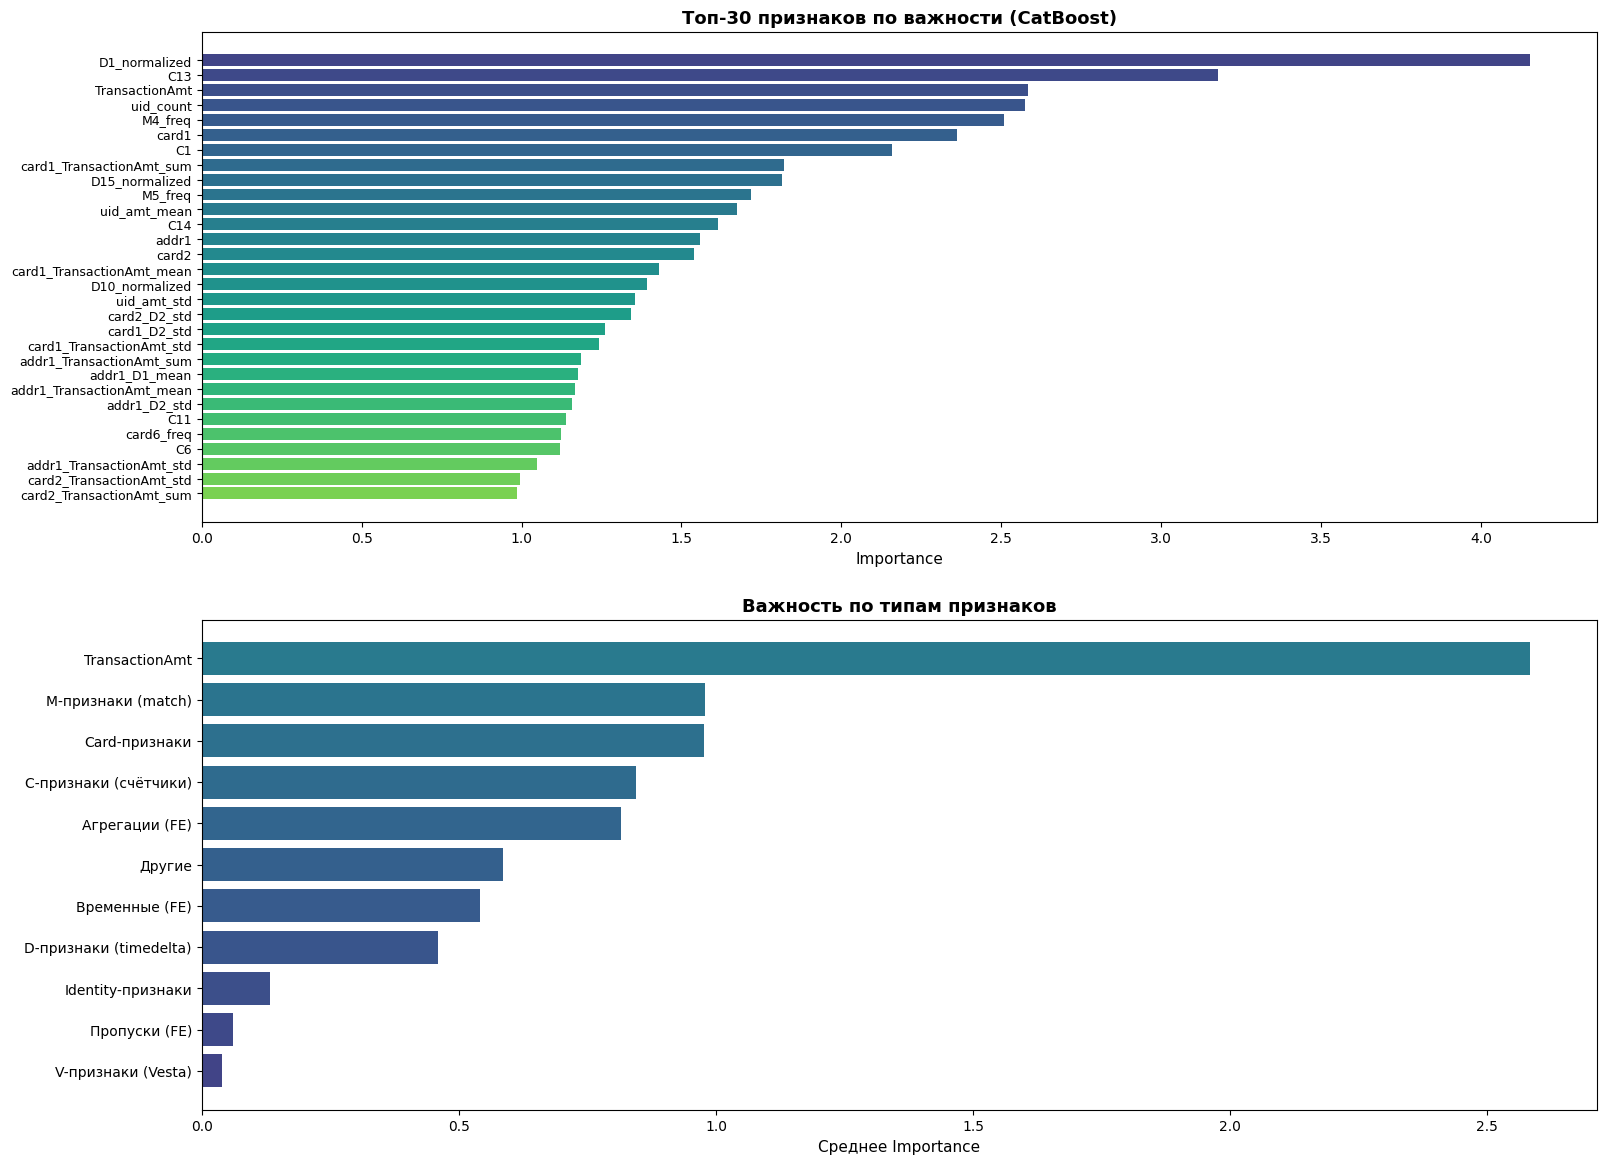

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(18, 14))

ax1 = axes[0]
top_n = 30
top_features = importance_df.head(top_n)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
bars = ax1.barh(range(top_n), top_features['importance'], color=colors)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features['feature'], fontsize=9)
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_title(f'Топ-{top_n} признаков по важности (CatBoost)', fontsize=13, fontweight='bold')
ax1.invert_yaxis()

ax2 = axes[1]
type_importance = importance_df.groupby('feature_type')['importance'].mean().sort_values(ascending=True)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
bars2 = ax2.barh(range(len(type_importance)), type_importance.values, color=colors)
ax2.set_yticks(range(len(type_importance)))
ax2.set_yticklabels(type_importance.index, fontsize=10)
ax2.set_xlabel('Среднее Importance', fontsize=11)
ax2.set_title('Важность по типам признаков', fontsize=13, fontweight='bold')

In [32]:
fig.savefig('reports/feature_importance.png', dpi=150, bbox_inches='tight')

In [33]:
top_features.head(30)

,feature,importance,rank,feature_type
0,D1_normalized,4.154294,1,D-признаки (timedelta)
1,C13,3.178767,2,C-признаки (счётчики)
2,TransactionAmt,2.583627,3,TransactionAmt
3,uid_count,2.574912,4,Агрегации (FE)
4,M4_freq,2.508956,5,M-признаки (match)
5,card1,2.363056,6,Card-признаки
6,C1,2.159002,7,C-признаки (счётчики)
7,card1_TransactionAmt_sum,1.820113,8,Card-признаки
8,D15_normalized,1.814087,9,D-признаки (timedelta)
9,M5_freq,1.716805,10,M-признаки (match)


## Выбор лучшей конфигурации

In [35]:
# Выбор лучшей конфигурации
if val_auc_config2 >= val_auc_config1:
    best_model = catboost_config2
    best_auc = val_auc_config2
    best_config_name = "CatBoost + Optuna"
else:
    best_model = catboost_config1
    best_auc = val_auc_config1
    best_config_name = "CatBoost (базовый)"

print(f"Лучшая конфигурация: {best_config_name}")
print(f"Validation ROC-AUC: {best_auc:.5f}")

Лучшая конфигурация: CatBoost + Optuna
Validation ROC-AUC: 0.93057


In [36]:
# Приводим колонки test к тому же формату что и train
test.columns = [col.replace("-", "_") for col in test.columns]
X_test = test.drop(columns=[id_col], errors='ignore')

X_test_processed = preprocessing_pipeline.transform(X_test)

test_predictions = best_model.predict_proba(X_test_processed)[:, 1]

submission = sample_sub.copy()
submission['isFraud'] = test_predictions

submission_path = SUBMISSIONS_DIR / f'catboost_my_solution.csv'
submission.to_csv(submission_path, index=False)